# Setup

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import numpy as np
import pandas as pd
from numpy import interp
from patsy import dmatrices
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
from joblib import Parallel, delayed
from sklearn.tree._tree import DTYPE
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone

In [82]:
train = pd.read_csv("data/train.csv")
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

def date_feat(month, day):
    return int(datetime.datetime.strptime("{} {}".format(month, day), '%b %d').date().strftime('%j'))

def pdays_feat(day):
    return -1 if day == -1 else day % 7

def transform(X):
    X['dayofyear_'] = np.vectorize(date_feat)(X['month'], X['day'])
    X['dayofweek']  = X['dayofyear_'] % 7
    X['pdayofweek'] = np.vectorize(pdays_feat)(X['pdays'])
    X = X.drop("dayofyear_", axis=1)
    X = X.drop("day", axis=1)
    X = X.drop("pdays", axis=1)
    return X

train_num = transform(train.copy())
train_num.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,previous,poutcome,y,dayofweek,pdayofweek
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,apr,939,1,0,unknown,1,2,-1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,feb,172,10,0,unknown,1,0,-1
2,3,36,management,single,tertiary,no,436,no,no,cellular,apr,567,1,2,failure,1,5,0
3,4,63,retired,married,secondary,no,474,no,no,cellular,jan,423,1,0,unknown,1,4,-1
4,5,31,management,single,tertiary,no,354,no,no,cellular,apr,502,1,2,success,1,1,2


In [85]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          27128 non-null  int64 
 1   age         27128 non-null  int64 
 2   job         27128 non-null  object
 3   marital     27128 non-null  object
 4   education   27128 non-null  object
 5   default     27128 non-null  object
 6   balance     27128 non-null  int64 
 7   housing     27128 non-null  object
 8   loan        27128 non-null  object
 9   contact     27128 non-null  object
 10  month       27128 non-null  object
 11  duration    27128 non-null  int64 
 12  campaign    27128 non-null  int64 
 13  previous    27128 non-null  int64 
 14  poutcome    27128 non-null  object
 15  y           27128 non-null  int64 
 16  dayofweek   27128 non-null  int64 
 17  pdayofweek  27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [86]:
y_, X_ = dmatrices(
    "y ~ age + job + marital + education + default + balance + housing + loan + contact + month + duration + campaign + previous + poutcome + dayofweek + pdayofweek",
    data=train_num,
    return_type='dataframe')
X = X_.values
y = y_.y.values
X_.head()

,Intercept,job[T.blue-collar],job[T.entrepreneur],job[T.housemaid],job[T.management],job[T.retired],job[T.self-employed],job[T.services],job[T.student],job[T.technician],...,poutcome[T.other],poutcome[T.success],poutcome[T.unknown],age,balance,duration,campaign,previous,dayofweek,pdayofweek
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,39.0,1756.0,939.0,1.0,0.0,2.0,-1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,51.0,1443.0,172.0,10.0,0.0,0.0,-1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,36.0,436.0,567.0,1.0,2.0,5.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,63.0,474.0,423.0,1.0,0.0,4.0,-1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,31.0,354.0,502.0,1.0,2.0,1.0,2.0


In [87]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27128 entries, 0 to 27127
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Intercept               27128 non-null  float64
 1   job[T.blue-collar]      27128 non-null  float64
 2   job[T.entrepreneur]     27128 non-null  float64
 3   job[T.housemaid]        27128 non-null  float64
 4   job[T.management]       27128 non-null  float64
 5   job[T.retired]          27128 non-null  float64
 6   job[T.self-employed]    27128 non-null  float64
 7   job[T.services]         27128 non-null  float64
 8   job[T.student]          27128 non-null  float64
 9   job[T.technician]       27128 non-null  float64
 10  job[T.unemployed]       27128 non-null  float64
 11  job[T.unknown]          27128 non-null  float64
 12  marital[T.married]      27128 non-null  float64
 13  marital[T.single]       27128 non-null  float64
 14  education[T.secondary]  27128 non-null

In [95]:
def evaluate(classifier, n_folds=6):
    kf = KFold(n_splits=n_folds)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    print("Calculating fold: ", end="")
    for i, (train, test) in enumerate(kf.split(X)):
        print(i+1, end=" ")
        classifier.fit(X[train], y[train])
        probas_ = classifier.predict_proba(X[test])[:, 1]
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

    print("done!", end="")
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [100]:
class GbdtLrClassifier(object):
    def __init__(self, n_estimators=100, max_depth=3, C=1.0, penalty='l2'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.C = C
        self.penalty = penalty
        self.gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
        self.lr_model = LogisticRegression(C=C, penalty=penalty)
        self.enc = OneHotEncoder()
        
    def fit(self, X, y):
        self.gbdt_model.fit(X, y)
        self.enc.fit(self.getEachTreeDecision(X))
        self.lr_model.fit(self.extractFeaturesByGBDT(X), y)
        return self
    
    def predict_proba(self, X):
        return self.lr_model.predict_proba(self.extractFeaturesByGBDT(X))
        
    def getEachTreeDecision(self, X):
        out = Parallel(n_jobs=4)(delayed(self.my_func)(self.gbdt_model.estimators_[i, 0].tree_, X) for i in range(self.gbdt_model.n_estimators))
        return np.transpose(np.array(out))
    
    def extractFeaturesByGBDT(self, X):
        return self.enc.transform(self.getEachTreeDecision(X)).toarray()
    
    def my_func(self, tree, X):
            return tree.apply(np.array(X, dtype=DTYPE))
        
    def clone(self):
        return GbdtLrClassifier(self.n_estimators, self.max_depth, self.C, self.penalty)

In [90]:
class BaggingKFoldClassifier(object):
    def __init__(self, base_classifiers, n_folds):
        self.classifiers = []
        self.base_classifiers = base_classifiers
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.classifiers = []
        kf = KFold(n_splits=self.n_folds)
        for base_classifier in self.base_classifiers:
            for i, (train, test) in enumerate(kf.split(X)):
                if hasattr(base_classifier, 'get_params'):
                    classifier = clone(base_classifier)
                else:
                    classifier = base_classifier.clone()
                classifier.fit(X[train], y[train])
                self.classifiers.append(classifier)
        return self
    
    def predict_proba(self, X):
        probas_list = []
        for classifier in self.classifiers:
            probas_list.append(classifier.predict_proba(X))
        return np.array(probas_list).mean(axis=0)

In [91]:
gbdt = GradientBoostingClassifier(
    n_estimators=500)
rf = RandomForestClassifier(
    n_estimators=2000,
    n_jobs=multiprocessing.cpu_count())
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=500,
    max_depth=3,
    gamma=0,
    min_child_weight=10)

Calculating fold: 1 2 3 4 5 6 done!

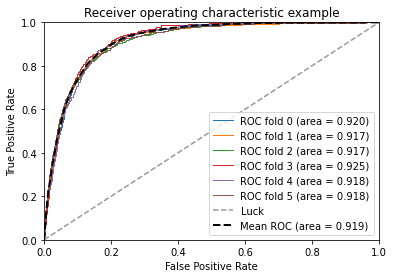

In [96]:
evaluate(BaggingKFoldClassifier([xgb], n_folds=6))

Calculating fold: 1 2 3 4 5 6 done!

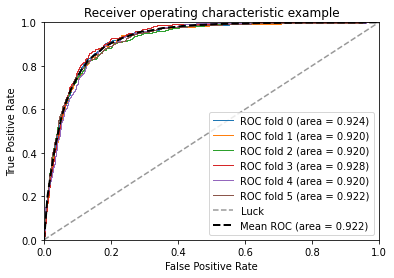

In [97]:
evaluate(BaggingKFoldClassifier([gbdt, xgb], n_folds=6))

Calculating fold: 1 2 3 4 5 6 done!

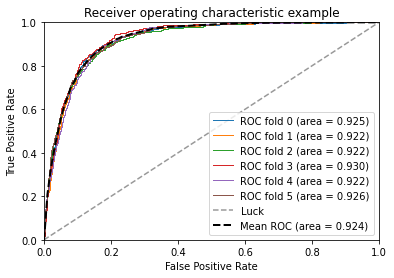

In [101]:
evaluate(BaggingKFoldClassifier([gbdt, rf], n_folds=6))